Overview: https://medium.com/towards-data-science/deep-learning-googlenet-explained-de8861c82765

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download delayedkarma/impressionist-classifier-data
! unzip impressionist-classifier-data.zip

100% 2.18G/2.19G [00:18<00:00, 220MB/s]
100% 2.19G/2.19G [00:19<00:00, 123MB/s]
Archive:  impressionist-classifier-data.zip
  inflating: training/training/Cezanne/215457.jpg  
  inflating: training/training/Cezanne/215458.jpg  
  inflating: training/training/Cezanne/215459.jpg  
  inflating: training/training/Cezanne/215460.jpg  
  inflating: training/training/Cezanne/215462.jpg  
  inflating: training/training/Cezanne/215463.jpg  
  inflating: training/training/Cezanne/215466.jpg  
  inflating: training/training/Cezanne/215467.jpg  
  inflating: training/training/Cezanne/215468.jpg  
  inflating: training/training/Cezanne/215469.jpg  
  inflating: training/training/Cezanne/215470.jpg  
  inflating: training/training/Cezanne/215471.jpg  
  inflating: training/training/Cezanne/215473.jpg  
  inflating: training/training/Cezanne/215474.jpg  
  inflating: training/training/Cezanne/215475.jpg  
  inflating: training/training/Cezanne/215476.jpg  
  inflating: training/training/Cezanne/21547

In [ ]:
import numpy as np
import pandas as pd
import os
import torchvision
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torch import Generator
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import itertools
import time
import copy
from torchvision.models import ResNet50_Weights
from torch.nn import Module
from torchvision import models
import torch.optim as optim
import seaborn as sns
import torchvision
import torch.nn as nn
from torch import manual_seed as torch_manual_seed
from torch.cuda import max_memory_allocated, set_device, manual_seed_all
from torch.backends import cudnn

In [ ]:
def setup_seed(seed):
    torch_manual_seed(seed)
    manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True

SEED = 6050
setup_seed(SEED)

In [ ]:
artists = ['Cezanne', 'Degas', 'Gauguin', 'Hassam', 'Matisse', 'Monet', 'Pissarro', 'Renoir', 'Sargent', 'VanGogh']
artists = os.listdir('training/training')

In [ ]:
transformation = Compose([
    Resize((256,256)),
    ToTensor()
])
transformation_train = Compose([
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20),
    ToTensor()
])

image_datasets = {}
# for phase in ['training', 'validation']:
#   image_datasets[phase] = ImageFolder(f'/content/{phase}/{phase}', transform=transformation)
image_datasets['training'] = ImageFolder(f'/content/training/training', transform=transformation_train)
image_datasets['validation'] = ImageFolder(f'/content/validation/validation', transform=transformation)

# size_all_train = len(image_datasets['training'])
# size_test_from_train = int(size_all_train * 0.125)
# size_train = size_all_train - size_test_from_train

# image_datasets['training'], image_datasets_test_from_train = random_split(image_datasets['training'], [size_train, size_test_from_train], generator=Generator().manual_seed(SEED))

# size_all_validation = len(image_datasets['validation'])
# size_test_from_validation = int(size_all_validation * 0.25)
# size_validation = size_all_validation - size_test_from_validation

# image_datasets['validation'], image_datasets_test_from_validation = random_split(image_datasets['validation'], [size_validation, size_test_from_validation], generator=Generator().manual_seed(SEED))

# image_datasets['testing'] = ConcatDataset([image_datasets_test_from_train, image_datasets_test_from_validation])

size_all_validation = len(image_datasets['validation'])
size_test_from_validation = int(size_all_validation * 0.5)
size_validation = size_all_validation - size_test_from_validation

image_datasets['validation'], image_datasets['testing'] = random_split(image_datasets['validation'], [size_validation, size_test_from_validation], generator=Generator().manual_seed(SEED))

# EDIT BATCH SIZE HERE (tune learning rate using 16, then, once the learning rate is fixed, try 32, 48, 64)
BS = 32
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BS, shuffle=True) for x in ['training', 'validation', 'testing']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['training', 'validation', 'testing']}
print(dataset_sizes)

# set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

{'training': 3988, 'validation': 495, 'testing': 495}
cuda:0


In [ ]:
for artist in artists:
    exec(f"train_{artist}_dir = os.path.join('training/training', '{artist}')")
    exec(f"train_{artist}_filenames = os.listdir(train_{artist}_dir)")
    exec(f"valid_{artist}_dir = os.path.join('validation/validation', '{artist}')")
    exec(f"valid_{artist}_filenames = os.listdir(valid_{artist}_dir)")

In [ ]:
# https://www.kaggle.com/code/delayedkarma/display-impressionist-images

def plot_imgs(artist, nrows=1, ncols=4, num_imgs=4):
    """
    Function to plot random sample images for each artist in a num_rows x num_cols grid
    :param artist: Artist name
    :type artist: str
    :param nrows: Number of rows in grid
    :type nrows: int
    :param ncols: Number of columns
    :type ncols: int
    :param num_imgs: Number of sample images to plot
    :type num_imgs: int
    :return: None
    """
    
    pic_idx = 0
    
    fig = plt.gcf()
    fig.set_size_inches(ncols * 6, nrows * 6)

    pic_idx += num_imgs

    train_dir = eval(f"train_{artist}_dir")
    filenames = eval(f"train_{artist}_filenames")
    filenames = random.sample(filenames, len(filenames))
    
    next_pix = [os.path.join(train_dir, fname) 
                    for fname in filenames[pic_idx-num_imgs: pic_idx]]


    for i, img_path in enumerate(next_pix):
        plt.suptitle(f"{artist}", fontsize=24)
        sp = plt.subplot(nrows, ncols, i + 1)
        sp.axis('Off') # Don't show axes (or gridlines)
        img = mpimg.imread(img_path)
        plt.imshow(img)

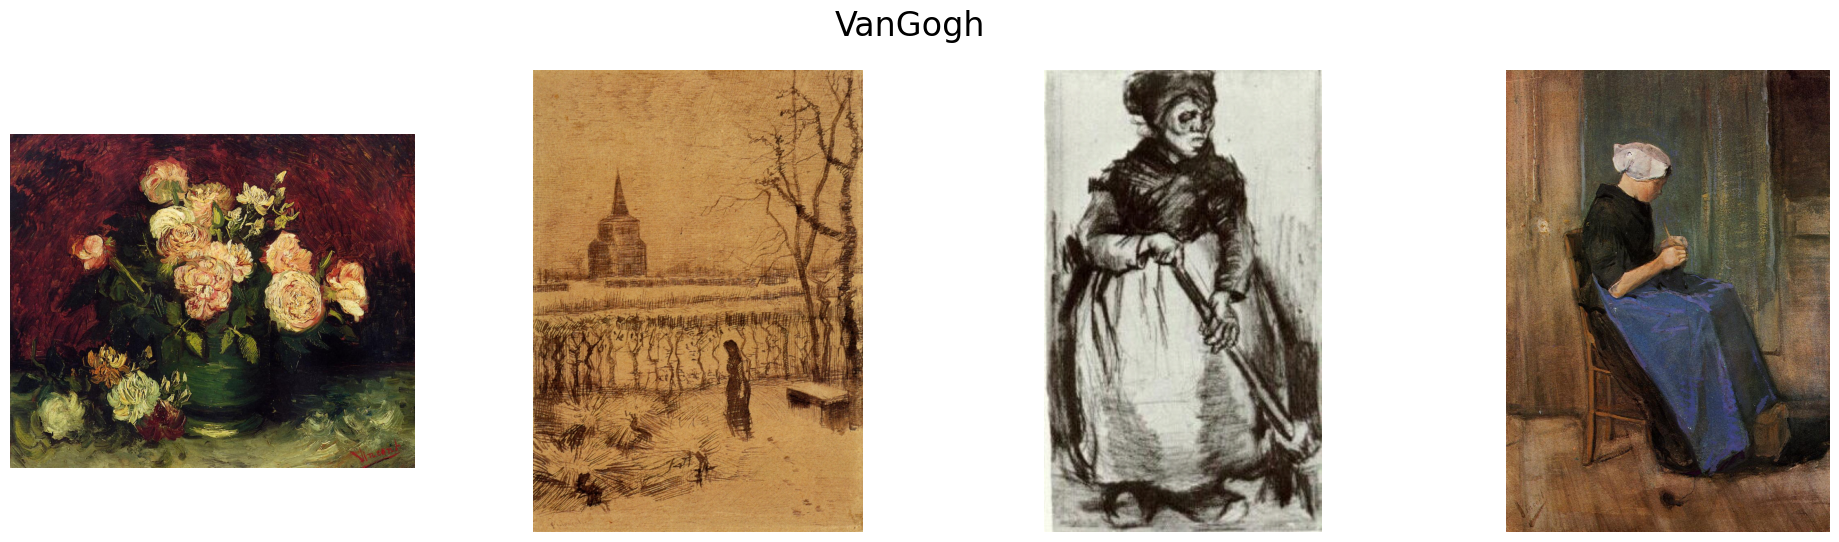

In [ ]:
plot_imgs(artists[0])

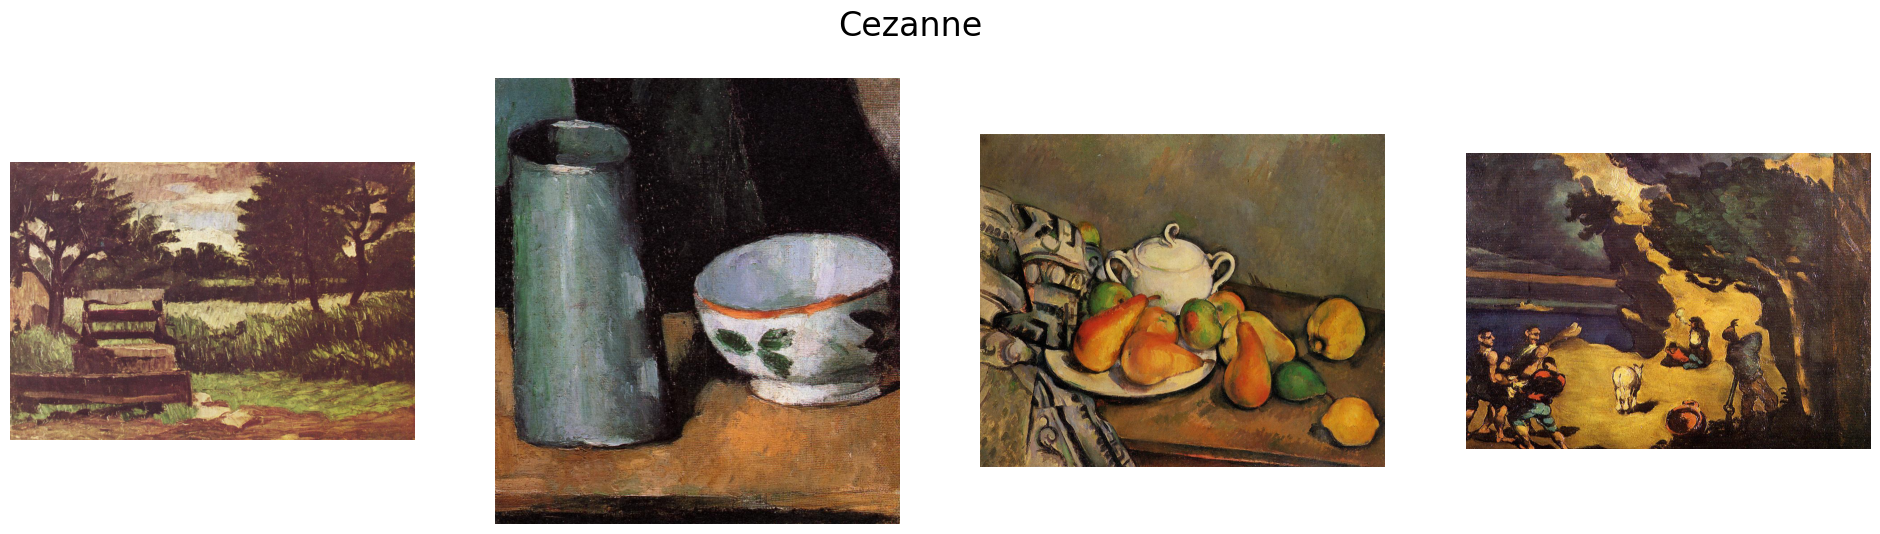

In [ ]:
plot_imgs(artists[1])

In [ ]:
sample_at = 1
k = int(np.floor(1/BS))

my_sample = next(itertools.islice(dataloaders['training'], k, None))
print (my_sample)

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
       

In [ ]:
sample_at = 1
k = int(np.floor(1/BS))

my_sample = next(itertools.islice(dataloaders['validation'], k, None))
print (my_sample)

[tensor([[[[0.5529, 0.4118, 0.4902,  ..., 0.7569, 0.7412, 0.6745],
          [0.5294, 0.4157, 0.5294,  ..., 0.6706, 0.6392, 0.6275],
          [0.5216, 0.3882, 0.4431,  ..., 0.6627, 0.6157, 0.6196],
          ...,
          [0.5922, 0.3098, 0.5137,  ..., 0.6431, 0.5059, 0.5569],
          [0.7882, 0.3804, 0.3686,  ..., 0.6549, 0.6118, 0.5804],
          [0.9216, 0.7882, 0.7216,  ..., 0.5765, 0.6314, 0.6431]],

         [[0.6078, 0.5020, 0.5529,  ..., 0.7961, 0.7804, 0.7255],
          [0.5804, 0.5137, 0.6000,  ..., 0.7490, 0.6980, 0.6902],
          [0.5725, 0.4863, 0.5294,  ..., 0.7412, 0.6824, 0.6902],
          ...,
          [0.5608, 0.2784, 0.4745,  ..., 0.5569, 0.4353, 0.5059],
          [0.7451, 0.3373, 0.3216,  ..., 0.5412, 0.5216, 0.5059],
          [0.8941, 0.7412, 0.6667,  ..., 0.4745, 0.5333, 0.5451]],

         [[0.6667, 0.5961, 0.6471,  ..., 0.8784, 0.8431, 0.8000],
          [0.6471, 0.6118, 0.7255,  ..., 0.8431, 0.7725, 0.7765],
          [0.6980, 0.6588, 0.7255,  ..., 

In [ ]:
sample_at = 1
k = int(np.floor(1/BS))

my_sample = next(itertools.islice(dataloaders['testing'], k, None))
print (my_sample)

[tensor([[[[0.5137, 0.5216, 0.5098,  ..., 0.6667, 0.6784, 0.6627],
          [0.5216, 0.5255, 0.5098,  ..., 0.6627, 0.6667, 0.6510],
          [0.5137, 0.4980, 0.5020,  ..., 0.6667, 0.6588, 0.6549],
          ...,
          [0.6627, 0.6824, 0.6902,  ..., 0.4196, 0.3333, 0.3529],
          [0.6667, 0.6824, 0.6980,  ..., 0.3608, 0.2549, 0.3333],
          [0.6275, 0.6667, 0.6863,  ..., 0.3725, 0.4118, 0.3804]],

         [[0.6824, 0.6941, 0.6863,  ..., 0.6745, 0.6863, 0.6784],
          [0.6824, 0.6902, 0.6745,  ..., 0.6824, 0.6863, 0.6824],
          [0.6706, 0.6745, 0.6745,  ..., 0.6863, 0.6941, 0.6980],
          ...,
          [0.6941, 0.7098, 0.7059,  ..., 0.3922, 0.3765, 0.4000],
          [0.6902, 0.7059, 0.7137,  ..., 0.4118, 0.3529, 0.3765],
          [0.6824, 0.6980, 0.7059,  ..., 0.4078, 0.4000, 0.4235]],

         [[0.7412, 0.7412, 0.7294,  ..., 0.5843, 0.6275, 0.6196],
          [0.7255, 0.7333, 0.7216,  ..., 0.6431, 0.6431, 0.6431],
          [0.7020, 0.7216, 0.7176,  ..., 

In [ ]:
# for debugging purposes
c = 0
for inputs, labels in dataloaders['testing']:
  inputs.to(device)
  labels.to(device)
  #print(c)
  c += 1

In [ ]:
# define the model training function
def train_model(model, criterion, optimizer, num_epochs=25):
    # initialize the start time
    since = time.time()

    # initialize the best weight configuration and accuracy of the model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # initialize the lists that will store the accuracies and losses across the epochs
    train_accs = []
    val_accs = []
    train_losses = []
    val_losses = []

    # iterate over the epochs
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # each epoch has a training and validation phase
        for phase in ['training', 'validation']:
            if phase == 'training':
                model.train()  # set model to training mode
            else:
                model.eval()   # set model to evaluate mode

            # initialize the running losses and corrects
            running_loss = 0.0
            running_corrects = 0

            # iterate over the data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward pass
                # track history if only in train
                with torch.set_grad_enabled(phase == 'training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward pass
                    # optimize only if in training phase
                    if phase == 'training':
                        loss.backward()
                        optimizer.step()

                # calculate and update epoch statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # print epoch performance statistics
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # store epoch performance statistics
            if phase == 'training':
              train_accs.append(epoch_acc.item())
              train_losses.append(epoch_loss)
            else:
              val_accs.append(epoch_acc.item())
              val_losses.append(epoch_loss)

            # deep copy the model to reflect the best weight configuration
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    # print the training statistics
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_accs, train_losses, val_accs, val_losses

In [ ]:
!pip install googlenet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Model 1: Pre-trained GoogLeNet (36 mins)
- batch_size= 32
- lr = 0.002
- Data Augmentation

$\therefore$ 0.689 Validation accuracy at epoch 10

In [ ]:
from googlenet_pytorch import GoogLeNet
model_google = GoogLeNet.from_pretrained("googlenet")
model_google = model_google.to(device)
model_google.aux_logits = False ### NEVER REMOVE THIS LINE

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 89.4MB/s]


Loaded pretrained weights for googlenet


In [ ]:
# define the loss function
criterion_1 = nn.CrossEntropyLoss()

# set the optimizer for the parameters of the fully connected head
optimizer_1 = optim.Adam(model_google.parameters(), lr=0.002)

In [ ]:
# # train the model for the desired number of epochs
model_1, train_accs_1, train_losses_1, val_accs_1, val_losses_1 = train_model(model_google, criterion_1, optimizer_1, num_epochs=10)

Epoch 1/10
----------
training Loss: 1.7035 Acc: 0.4674
validation Loss: 1.9143 Acc: 0.3879

Epoch 2/10
----------
training Loss: 1.2899 Acc: 0.5732
validation Loss: 1.7204 Acc: 0.4727

Epoch 3/10
----------
training Loss: 1.1441 Acc: 0.6291
validation Loss: 1.9296 Acc: 0.4687

Epoch 4/10
----------
training Loss: 1.0649 Acc: 0.6432
validation Loss: 1.9938 Acc: 0.4727

Epoch 5/10
----------
training Loss: 1.0029 Acc: 0.6622
validation Loss: 1.2365 Acc: 0.6101

Epoch 6/10
----------
training Loss: 0.9355 Acc: 0.6943
validation Loss: 1.4682 Acc: 0.5677

Epoch 7/10
----------
training Loss: 0.8724 Acc: 0.7096
validation Loss: 1.5347 Acc: 0.5859

Epoch 8/10
----------
training Loss: 0.8161 Acc: 0.7269
validation Loss: 1.0728 Acc: 0.6768

Epoch 9/10
----------
training Loss: 0.7678 Acc: 0.7462
validation Loss: 2.0887 Acc: 0.4566

Epoch 10/10
----------
training Loss: 0.7201 Acc: 0.7585
validation Loss: 0.9816 Acc: 0.6889

Training complete in 36m 56s
Best val Acc: 0.688889


Text(0.5, 1.0, 'Loss')

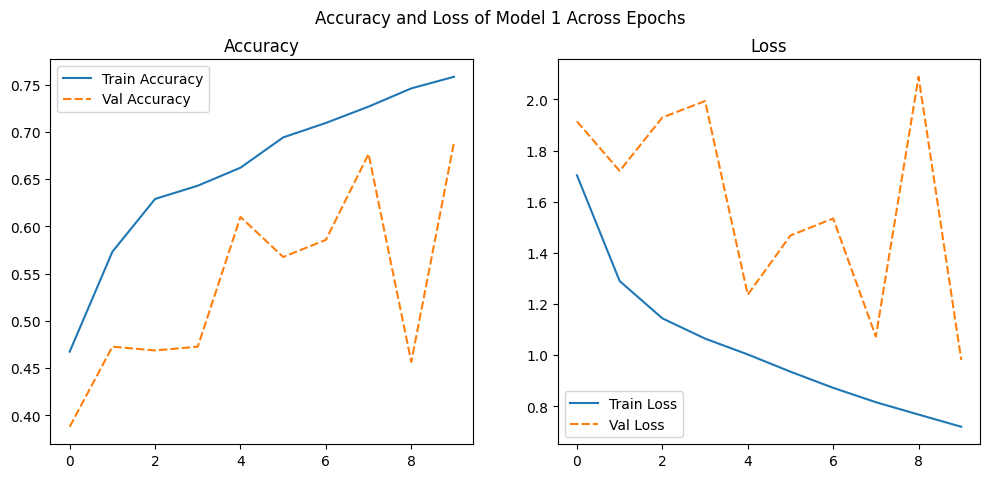

In [ ]:
data_acc_1 = pd.DataFrame({"Train Accuracy": train_accs_1, "Val Accuracy": val_accs_1})
data_loss_1 = pd.DataFrame({"Train Loss": train_losses_1, "Val Loss": val_losses_1})

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

plt.suptitle("Accuracy and Loss of Model 1 Across Epochs")

sns.lineplot(data=data_acc_1, ax = axs[0])
axs[0].set_title("Accuracy")


sns.lineplot(data=data_loss_1, ax = axs[1])
axs[1].set_title("Loss")

In [ ]:
result_1 = pd.concat([data_acc_1, data_loss_1], axis = 1)
result_1

,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.467402,0.387879,1.703536,1.914318
1,0.573220,0.472727,1.289907,1.720447
2,0.629137,0.468687,1.144102,1.929646
3,0.643180,0.472727,1.064850,1.993841
4,0.662237,0.610101,1.002934,1.236546
5,0.694333,0.567677,0.935483,1.468168
6,0.709629,0.585859,0.872412,1.534661
7,0.726931,0.676768,0.816136,1.072770
8,0.746239,0.456566,0.767830,2.088748
9,0.758526,0.688889,0.720055,0.981565


In [ ]:
result_1.to_csv("result_1.csv")

In [ ]:
with open('/content/drive/My Drive/filename.extension', 'w') as f:
  f.write("result_1.csv")

## Model 2: Fine-tuned GoogLeNet (32 mins)
- batch_size = 32
- learning_rate = 0.0005
- weight_decay = 1e-5
-  Data Augmentation

$\therefore$ Validation accuracy 0.759 at epoch 9

In [ ]:
BS = 32
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BS, shuffle=True) for x in ['training', 'validation', 'testing']}

In [ ]:
from googlenet_pytorch import GoogLeNet
model_google = GoogLeNet.from_pretrained("googlenet")

# freeze all of the parameters in the model
for param in model_google.parameters():
  param.requires_grad = False
# unfreeze the parameters in the last residual block of the architecture
for name, param in model_google.named_parameters():
  for i in [4]:
    if name.startswith(f'layer{i}'):
      param.requires_grad = True

# EDIT DROPOUT RATE HERE (dropout actually doesn't help here, so let's use L2 regularization instead)
DO = 0.0
# construct the fully connected head which will receive the flattened convolutional output

'''
The final layer of GoogLeNet is a global average pooling layer that reduces the spatial 
dimensions of the feature maps to 1x1 and produces a tensor of size (1, 1024).
''' 
model_google.fc = nn.Sequential(
               nn.Linear(1024, 512), # 2048 -> 1024
               nn.BatchNorm1d(512),
               nn.ReLU(inplace=True),
               nn.Dropout(DO),
               
               nn.Linear(512, 128),
               nn.BatchNorm1d(128),
               nn.ReLU(inplace=True),
               nn.Dropout(DO),

              #  nn.Linear(128, 32),
              #  nn.BatchNorm1d(32),
              #  nn.ReLU(inplace=True),
              #  #nn.Dropout(DO),

               nn.Linear(128, len(artists)))

# print all the named parameters in the model to confirm that the correct ones are frozen and unfrozen
for name, param in model_google.named_parameters():
  print(name, param.requires_grad)

model_google = model_google.to(device)
model_google.aux_logits = False ### NEVER REMOVE THIS LINE

Loaded pretrained weights for googlenet
conv1.conv.weight False
conv1.bn.weight False
conv1.bn.bias False
conv2.conv.weight False
conv2.bn.weight False
conv2.bn.bias False
conv3.conv.weight False
conv3.bn.weight False
conv3.bn.bias False
inception3a.branch1.conv.weight False
inception3a.branch1.bn.weight False
inception3a.branch1.bn.bias False
inception3a.branch2.0.conv.weight False
inception3a.branch2.0.bn.weight False
inception3a.branch2.0.bn.bias False
inception3a.branch2.1.conv.weight False
inception3a.branch2.1.bn.weight False
inception3a.branch2.1.bn.bias False
inception3a.branch3.0.conv.weight False
inception3a.branch3.0.bn.weight False
inception3a.branch3.0.bn.bias False
inception3a.branch3.1.conv.weight False
inception3a.branch3.1.bn.weight False
inception3a.branch3.1.bn.bias False
inception3a.branch4.1.conv.weight False
inception3a.branch4.1.bn.weight False
inception3a.branch4.1.bn.bias False
inception3b.branch1.conv.weight False
inception3b.branch1.bn.weight False
inception3

In [ ]:
# define the loss function
criterion_2 = nn.CrossEntropyLoss()

# EDIT LEARNING RATE HERE (tune 0.01, 0.001, 0.0001 with batch size of 16)
LR = 0.0005 # (fixed)

# EDIT WEIGHT DECAY (L2 REGULARIZATION) HERE (tune 1e-5, 1e-4, 1e-3)
WD = 1e-5

# set the optimizer for the parameters of the whole model
optimizer_2 = optim.Adam(filter(lambda p: p.requires_grad, model_google.parameters()), lr=LR, weight_decay=WD)

In [ ]:
# # train the model for the desired number of epochs
model_2, train_accs_2, train_losses_2, val_accs_2, val_losses_2 = train_model(model_google, criterion_2, optimizer_2, num_epochs=10)

Epoch 1/10
----------
training Loss: 1.5222 Acc: 0.5191
validation Loss: 1.1278 Acc: 0.6566

Epoch 2/10
----------
training Loss: 1.1118 Acc: 0.6459
validation Loss: 0.9887 Acc: 0.6566

Epoch 3/10
----------
training Loss: 0.9942 Acc: 0.6755
validation Loss: 0.9435 Acc: 0.6949

Epoch 4/10
----------
training Loss: 0.9439 Acc: 0.6838
validation Loss: 0.8946 Acc: 0.6808

Epoch 5/10
----------
training Loss: 0.8982 Acc: 0.6946
validation Loss: 0.8557 Acc: 0.7152

Epoch 6/10
----------
training Loss: 0.8537 Acc: 0.7134
validation Loss: 0.8345 Acc: 0.7131

Epoch 7/10
----------
training Loss: 0.8239 Acc: 0.7232
validation Loss: 0.8410 Acc: 0.7051

Epoch 8/10
----------
training Loss: 0.8056 Acc: 0.7267
validation Loss: 0.8337 Acc: 0.7232

Epoch 9/10
----------
training Loss: 0.7796 Acc: 0.7367
validation Loss: 0.7711 Acc: 0.7596

Epoch 10/10
----------
training Loss: 0.7364 Acc: 0.7520
validation Loss: 0.7574 Acc: 0.7556

Training complete in 32m 55s
Best val Acc: 0.759596


Text(0.5, 1.0, 'Loss')

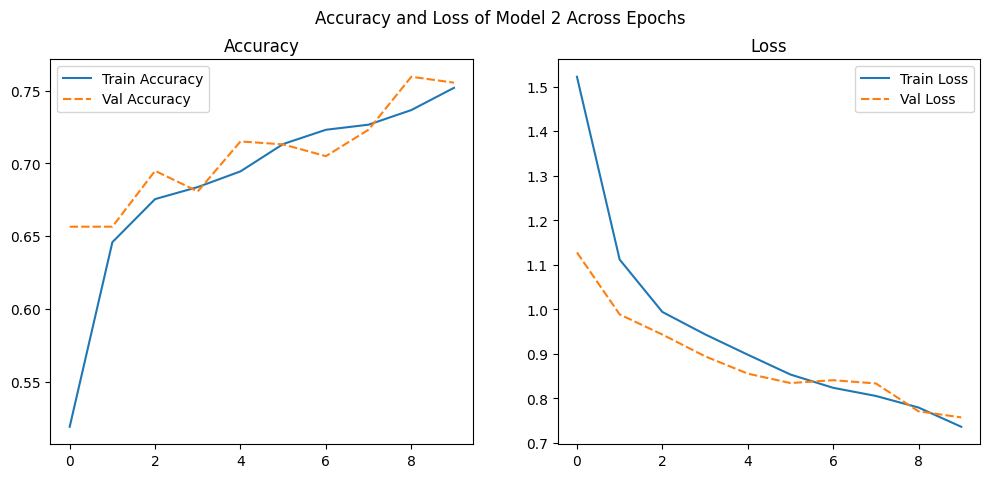

In [ ]:
data_acc_2 = pd.DataFrame({"Train Accuracy": train_accs_2, "Val Accuracy": val_accs_2})
data_loss_2 = pd.DataFrame({"Train Loss": train_losses_2, "Val Loss": val_losses_2})

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

plt.suptitle("Accuracy and Loss of Model 2 Across Epochs")

sns.lineplot(data=data_acc_2, ax = axs[0])
axs[0].set_title("Accuracy")


sns.lineplot(data=data_loss_2, ax = axs[1])
axs[1].set_title("Loss")

In [ ]:
result_2 = pd.concat([data_acc_2, data_loss_2], axis = 1)
result_2

,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.519057,0.656566,1.522231,1.127769
1,0.645938,0.656566,1.111816,0.988681
2,0.675527,0.694949,0.994216,0.943501
3,0.683801,0.680808,0.943940,0.894618
4,0.694584,0.715152,0.898241,0.855690
5,0.713390,0.713131,0.853670,0.834545
6,0.723170,0.705051,0.823900,0.840962
7,0.726680,0.723232,0.805624,0.833674
8,0.736710,0.759596,0.779581,0.771083
9,0.752006,0.755556,0.736389,0.757416


In [ ]:
result_2.to_csv("result_2.csv")

In [ ]:
with open('/content/drive/My Drive/filename.extension', 'w') as f:
  f.write("result_2.csv")

In [ ]:
model_save_name = 'googlenet_final.pt'
path = f"/content/drive/MyDrive/{model_save_name}" 
torch.save(model_google.state_dict(), path)

## Model 3: Fine-tuned GoogLeNet (34 mins)
- batch_size = 48
- learning_rate = 0.0005
- weight_decay = 1e-5
-  Data Augmentation

$\therefore$ Validation accuracy 0.743 at epoch 10

In [ ]:
BS = 48
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BS, shuffle=True) for x in ['training', 'validation', 'testing']}

In [ ]:
from googlenet_pytorch import GoogLeNet
model_google = GoogLeNet.from_pretrained("googlenet")

# freeze all of the parameters in the model
for param in model_google.parameters():
  param.requires_grad = False
# unfreeze the parameters in the last residual block of the architecture
for name, param in model_google.named_parameters():
  for i in [4]:
    if name.startswith(f'layer{i}'):
      param.requires_grad = True

# EDIT DROPOUT RATE HERE (dropout actually doesn't help here, so let's use L2 regularization instead)
DO = 0.0
# construct the fully connected head which will receive the flattened convolutional output
model_google.fc = nn.Sequential(
               nn.Linear(1024, 512), # 2048 -> 1024
               nn.BatchNorm1d(512),
               nn.ReLU(inplace=True),
               nn.Dropout(DO),
               
               nn.Linear(512, 128),
               nn.BatchNorm1d(128),
               nn.ReLU(inplace=True),
               nn.Dropout(DO),

              #  nn.Linear(128, 32),
              #  nn.BatchNorm1d(32),
              #  nn.ReLU(inplace=True),
              #  #nn.Dropout(DO),

               nn.Linear(128, len(artists)))

# print all the named parameters in the model to confirm that the correct ones are frozen and unfrozen
for name, param in model_google.named_parameters():
  print(name, param.requires_grad)

model_google = model_google.to(device)
model_google.aux_logits = False ### NEVER REMOVE THIS LINE

Loaded pretrained weights for googlenet
conv1.conv.weight False
conv1.bn.weight False
conv1.bn.bias False
conv2.conv.weight False
conv2.bn.weight False
conv2.bn.bias False
conv3.conv.weight False
conv3.bn.weight False
conv3.bn.bias False
inception3a.branch1.conv.weight False
inception3a.branch1.bn.weight False
inception3a.branch1.bn.bias False
inception3a.branch2.0.conv.weight False
inception3a.branch2.0.bn.weight False
inception3a.branch2.0.bn.bias False
inception3a.branch2.1.conv.weight False
inception3a.branch2.1.bn.weight False
inception3a.branch2.1.bn.bias False
inception3a.branch3.0.conv.weight False
inception3a.branch3.0.bn.weight False
inception3a.branch3.0.bn.bias False
inception3a.branch3.1.conv.weight False
inception3a.branch3.1.bn.weight False
inception3a.branch3.1.bn.bias False
inception3a.branch4.1.conv.weight False
inception3a.branch4.1.bn.weight False
inception3a.branch4.1.bn.bias False
inception3b.branch1.conv.weight False
inception3b.branch1.bn.weight False
inception3

In [ ]:
# define the loss function
criterion_3 = nn.CrossEntropyLoss()

# EDIT LEARNING RATE HERE (tune 0.01, 0.001, 0.0001 with batch size of 16)
LR = 0.0005 # (fixed)

# EDIT WEIGHT DECAY (L2 REGULARIZATION) HERE (tune 1e-5, 1e-4, 1e-3)
WD = 1e-5

# set the optimizer for the parameters of the whole model
optimizer_3 = optim.Adam(filter(lambda p: p.requires_grad, model_google.parameters()), lr=LR, weight_decay=WD)

In [ ]:
# # train the model for the desired number of epochs
model_3, train_accs_3, train_losses_3, val_accs_3, val_losses_3 = train_model(model_google, criterion_3, optimizer_3, num_epochs=10)

Epoch 1/10
----------
training Loss: 1.5802 Acc: 0.5028
validation Loss: 1.1557 Acc: 0.6061

Epoch 2/10
----------
training Loss: 1.1250 Acc: 0.6429
validation Loss: 1.0006 Acc: 0.6727

Epoch 3/10
----------
training Loss: 0.9872 Acc: 0.6763
validation Loss: 0.9142 Acc: 0.7071

Epoch 4/10
----------
training Loss: 0.9319 Acc: 0.6928
validation Loss: 0.9257 Acc: 0.6848

Epoch 5/10
----------
training Loss: 0.8769 Acc: 0.7101
validation Loss: 0.8831 Acc: 0.6970

Epoch 6/10
----------
training Loss: 0.8552 Acc: 0.7126
validation Loss: 0.8496 Acc: 0.7293

Epoch 7/10
----------
training Loss: 0.7944 Acc: 0.7335
validation Loss: 0.8417 Acc: 0.7232

Epoch 8/10
----------
training Loss: 0.7785 Acc: 0.7402
validation Loss: 0.8290 Acc: 0.7273

Epoch 9/10
----------
training Loss: 0.7539 Acc: 0.7395
validation Loss: 0.8094 Acc: 0.7374

Epoch 10/10
----------
training Loss: 0.7082 Acc: 0.7681
validation Loss: 0.7824 Acc: 0.7434

Training complete in 34m 6s
Best val Acc: 0.743434


Text(0.5, 1.0, 'Loss')

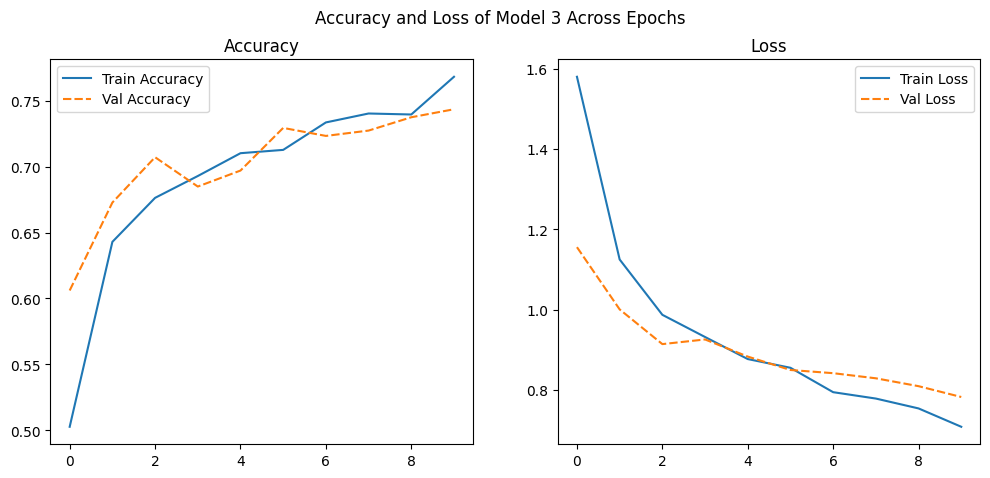

In [ ]:
data_acc_3 = pd.DataFrame({"Train Accuracy": train_accs_3, "Val Accuracy": val_accs_3})
data_loss_3 = pd.DataFrame({"Train Loss": train_losses_3, "Val Loss": val_losses_3})

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

plt.suptitle("Accuracy and Loss of Model 3 Across Epochs")

sns.lineplot(data=data_acc_3, ax = axs[0])
axs[0].set_title("Accuracy")


sns.lineplot(data=data_loss_3, ax = axs[1])
axs[1].set_title("Loss")

In [ ]:
result_3 = pd.concat([data_acc_3, data_loss_3], axis = 1)
result_3

,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.502758,0.606061,1.580249,1.155704
1,0.642929,0.672727,1.124992,1.000607
2,0.676279,0.707071,0.987163,0.914163
3,0.692828,0.684848,0.931882,0.925744
4,0.710130,0.696970,0.876893,0.883079
5,0.712638,0.729293,0.855165,0.849647
6,0.733450,0.723232,0.794381,0.841730
7,0.740221,0.727273,0.778498,0.828965
8,0.739468,0.737374,0.753895,0.809350
9,0.768054,0.743434,0.708181,0.782369


In [ ]:
result_3.to_csv("result_3.csv")

In [ ]:
with open('/content/drive/My Drive/filename.extension', 'w') as f:
  f.write("result_3.csv")

## Model 4: Fine-tuned GoogLeNet (32 mins)
- batch_size = 48
- learning_rate = 0.0005
- weight_decay = 1e-5
-  Data Augmentation
- Resized train data's images 224 x 224 (default size for GoogLeNet)

$\therefore$ Validation accuracy 0.719 at epoch 9

In [ ]:
transformation = Compose([
    Resize((224,224)),
    ToTensor()
])
transformation_train = Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20),
    ToTensor()
])

image_datasets = {}
# for phase in ['training', 'validation']:
#   image_datasets[phase] = ImageFolder(f'/content/{phase}/{phase}', transform=transformation)
image_datasets['training'] = ImageFolder(f'/content/training/training', transform=transformation_train)
image_datasets['validation'] = ImageFolder(f'/content/validation/validation', transform=transformation)

# size_all_train = len(image_datasets['training'])
# size_test_from_train = int(size_all_train * 0.125)
# size_train = size_all_train - size_test_from_train

# image_datasets['training'], image_datasets_test_from_train = random_split(image_datasets['training'], [size_train, size_test_from_train], generator=Generator().manual_seed(SEED))

# size_all_validation = len(image_datasets['validation'])
# size_test_from_validation = int(size_all_validation * 0.25)
# size_validation = size_all_validation - size_test_from_validation

# image_datasets['validation'], image_datasets_test_from_validation = random_split(image_datasets['validation'], [size_validation, size_test_from_validation], generator=Generator().manual_seed(SEED))

# image_datasets['testing'] = ConcatDataset([image_datasets_test_from_train, image_datasets_test_from_validation])

size_all_validation = len(image_datasets['validation'])
size_test_from_validation = int(size_all_validation * 0.5)
size_validation = size_all_validation - size_test_from_validation

image_datasets['validation'], image_datasets['testing'] = random_split(image_datasets['validation'], [size_validation, size_test_from_validation], generator=Generator().manual_seed(SEED))

# EDIT BATCH SIZE HERE (tune learning rate using 16, then, once the learning rate is fixed, try 32, 48, 64)
BS = 48
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BS, shuffle=True) for x in ['training', 'validation', 'testing']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['training', 'validation', 'testing']}
print(dataset_sizes)

# set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

{'training': 3988, 'validation': 495, 'testing': 495}
cuda:0


In [ ]:
from googlenet_pytorch import GoogLeNet
model_google = GoogLeNet.from_pretrained("googlenet")

# freeze all of the parameters in the model
for param in model_google.parameters():
  param.requires_grad = False
# unfreeze the parameters in the last residual block of the architecture
for name, param in model_google.named_parameters():
  for i in [4]:
    if name.startswith(f'layer{i}'):
      param.requires_grad = True

# EDIT DROPOUT RATE HERE (dropout actually doesn't help here, so let's use L2 regularization instead)
DO = 0.0
# construct the fully connected head which will receive the flattened convolutional output
model_google.fc = nn.Sequential(
               nn.Linear(1024, 512), # 2048 -> 1024
               nn.BatchNorm1d(512),
               nn.ReLU(inplace=True),
               nn.Dropout(DO),
               
               nn.Linear(512, 128),
               nn.BatchNorm1d(128),
               nn.ReLU(inplace=True),
               nn.Dropout(DO),

              #  nn.Linear(128, 32),
              #  nn.BatchNorm1d(32),
              #  nn.ReLU(inplace=True),
              #  #nn.Dropout(DO),

               nn.Linear(128, len(artists)))

# print all the named parameters in the model to confirm that the correct ones are frozen and unfrozen
for name, param in model_google.named_parameters():
  print(name, param.requires_grad)

model_google = model_google.to(device)
model_google.aux_logits = False ### NEVER REMOVE THIS LINE

Loaded pretrained weights for googlenet
conv1.conv.weight False
conv1.bn.weight False
conv1.bn.bias False
conv2.conv.weight False
conv2.bn.weight False
conv2.bn.bias False
conv3.conv.weight False
conv3.bn.weight False
conv3.bn.bias False
inception3a.branch1.conv.weight False
inception3a.branch1.bn.weight False
inception3a.branch1.bn.bias False
inception3a.branch2.0.conv.weight False
inception3a.branch2.0.bn.weight False
inception3a.branch2.0.bn.bias False
inception3a.branch2.1.conv.weight False
inception3a.branch2.1.bn.weight False
inception3a.branch2.1.bn.bias False
inception3a.branch3.0.conv.weight False
inception3a.branch3.0.bn.weight False
inception3a.branch3.0.bn.bias False
inception3a.branch3.1.conv.weight False
inception3a.branch3.1.bn.weight False
inception3a.branch3.1.bn.bias False
inception3a.branch4.1.conv.weight False
inception3a.branch4.1.bn.weight False
inception3a.branch4.1.bn.bias False
inception3b.branch1.conv.weight False
inception3b.branch1.bn.weight False
inception3

In [ ]:
# define the loss function
criterion_4 = nn.CrossEntropyLoss()

# EDIT LEARNING RATE HERE (tune 0.01, 0.001, 0.0001 with batch size of 16)
LR = 0.0005 # (fixed)

# EDIT WEIGHT DECAY (L2 REGULARIZATION) HERE (tune 1e-5, 1e-4, 1e-3)
WD = 1e-5

# set the optimizer for the parameters of the whole model
optimizer_4 = optim.Adam(filter(lambda p: p.requires_grad, model_google.parameters()), lr=LR, weight_decay=WD)

In [ ]:
# # train the model for the desired number of epochs
model_4, train_accs_4, train_losses_4, val_accs_4, val_losses_4 = train_model(model_google, criterion_4, optimizer_4, num_epochs=10)

Epoch 1/10
----------
training Loss: 1.6168 Acc: 0.4829
validation Loss: 1.1746 Acc: 0.6141

Epoch 2/10
----------
training Loss: 1.1827 Acc: 0.6266
validation Loss: 1.0109 Acc: 0.6667

Epoch 3/10
----------
training Loss: 1.0613 Acc: 0.6565
validation Loss: 0.9645 Acc: 0.6909

Epoch 4/10
----------
training Loss: 0.9803 Acc: 0.6763
validation Loss: 0.9453 Acc: 0.6848

Epoch 5/10
----------
training Loss: 0.9312 Acc: 0.6863
validation Loss: 0.8722 Acc: 0.6970

Epoch 6/10
----------
training Loss: 0.8753 Acc: 0.7046
validation Loss: 0.8558 Acc: 0.7071

Epoch 7/10
----------
training Loss: 0.8582 Acc: 0.7084
validation Loss: 0.8695 Acc: 0.7111

Epoch 8/10
----------
training Loss: 0.8265 Acc: 0.7214
validation Loss: 0.8366 Acc: 0.7111

Epoch 9/10
----------
training Loss: 0.8311 Acc: 0.7151
validation Loss: 0.8672 Acc: 0.7192

Epoch 10/10
----------
training Loss: 0.7839 Acc: 0.7365
validation Loss: 0.8802 Acc: 0.7030

Training complete in 32m 13s
Best val Acc: 0.719192


Text(0.5, 1.0, 'Loss')

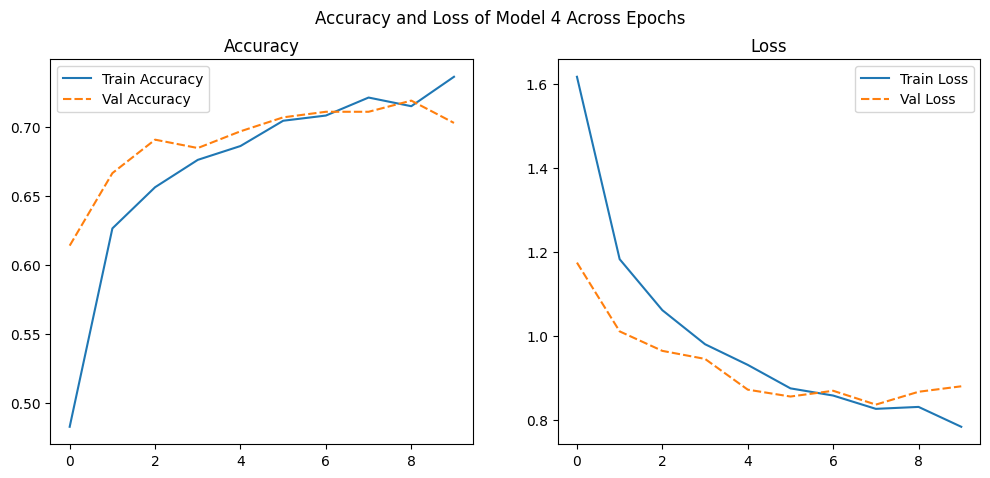

In [ ]:
data_acc_4 = pd.DataFrame({"Train Accuracy": train_accs_4, "Val Accuracy": val_accs_4})
data_loss_4 = pd.DataFrame({"Train Loss": train_losses_4, "Val Loss": val_losses_4})

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

plt.suptitle("Accuracy and Loss of Model 4 Across Epochs")

sns.lineplot(data=data_acc_4, ax = axs[0])
axs[0].set_title("Accuracy")


sns.lineplot(data=data_loss_4, ax = axs[1])
axs[1].set_title("Loss")

In [ ]:
result_4 = pd.concat([data_acc_4, data_loss_4], axis = 1)
result_4

,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.482949,0.614141,1.616816,1.174558
1,0.626630,0.666667,1.182689,1.010867
2,0.656469,0.690909,1.061305,0.964495
3,0.676279,0.684848,0.980281,0.945344
4,0.686309,0.696970,0.931175,0.872200
5,0.704614,0.707071,0.875262,0.855828
6,0.708375,0.711111,0.858159,0.869541
7,0.721414,0.711111,0.826519,0.836625
8,0.715145,0.719192,0.831126,0.867159
9,0.736459,0.703030,0.783851,0.880180


In [ ]:
with open('/content/drive/My Drive/filename.extension', 'w') as f:
  f.write("result_4.csv")

## Model 5: Fine-tuned GoogLeNet (31 mins)
- batch_size = 16
- learning_rate = 0.0005
- weight_decay = 1e-5
-  Data Augmentation

$\therefore$ Validation accuracy 0.709 at epoch 9

In [ ]:
BS = 16
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BS, shuffle=True) for x in ['training', 'validation', 'testing']}

In [ ]:
from googlenet_pytorch import GoogLeNet
model_google = GoogLeNet.from_pretrained("googlenet")

# freeze all of the parameters in the model
for param in model_google.parameters():
  param.requires_grad = False
# unfreeze the parameters in the last residual block of the architecture
for name, param in model_google.named_parameters():
  for i in [4]:
    if name.startswith(f'layer{i}'):
      param.requires_grad = True

# EDIT DROPOUT RATE HERE (dropout actually doesn't help here, so let's use L2 regularization instead)
DO = 0.0
# construct the fully connected head which will receive the flattened convolutional output
model_google.fc = nn.Sequential(
               nn.Linear(1024, 512), # 2048 -> 1024
               nn.BatchNorm1d(512),
               nn.ReLU(inplace=True),
               nn.Dropout(DO),
               
               nn.Linear(512, 128),
               nn.BatchNorm1d(128),
               nn.ReLU(inplace=True),
               nn.Dropout(DO),

              #  nn.Linear(128, 32),
              #  nn.BatchNorm1d(32),
              #  nn.ReLU(inplace=True),
              #  #nn.Dropout(DO),

               nn.Linear(128, len(artists)))

# print all the named parameters in the model to confirm that the correct ones are frozen and unfrozen
for name, param in model_google.named_parameters():
  print(name, param.requires_grad)

model_google = model_google.to(device)
model_google.aux_logits = False ### NEVER REMOVE THIS LINE

Loaded pretrained weights for googlenet
conv1.conv.weight False
conv1.bn.weight False
conv1.bn.bias False
conv2.conv.weight False
conv2.bn.weight False
conv2.bn.bias False
conv3.conv.weight False
conv3.bn.weight False
conv3.bn.bias False
inception3a.branch1.conv.weight False
inception3a.branch1.bn.weight False
inception3a.branch1.bn.bias False
inception3a.branch2.0.conv.weight False
inception3a.branch2.0.bn.weight False
inception3a.branch2.0.bn.bias False
inception3a.branch2.1.conv.weight False
inception3a.branch2.1.bn.weight False
inception3a.branch2.1.bn.bias False
inception3a.branch3.0.conv.weight False
inception3a.branch3.0.bn.weight False
inception3a.branch3.0.bn.bias False
inception3a.branch3.1.conv.weight False
inception3a.branch3.1.bn.weight False
inception3a.branch3.1.bn.bias False
inception3a.branch4.1.conv.weight False
inception3a.branch4.1.bn.weight False
inception3a.branch4.1.bn.bias False
inception3b.branch1.conv.weight False
inception3b.branch1.bn.weight False
inception3

In [ ]:
# define the loss function
criterion_5 = nn.CrossEntropyLoss()

# EDIT LEARNING RATE HERE (tune 0.01, 0.001, 0.0001 with batch size of 16)
LR = 0.0005 # (fixed)

# EDIT WEIGHT DECAY (L2 REGULARIZATION) HERE (tune 1e-5, 1e-4, 1e-3)
WD = 1e-5

# set the optimizer for the parameters of the whole model
optimizer_5 = optim.Adam(filter(lambda p: p.requires_grad, model_google.parameters()), lr=LR, weight_decay=WD)

In [ ]:
# # train the model for the desired number of epochs
model_5, train_accs_5, train_losses_5, val_accs_5, val_losses_5 = train_model(model_google, criterion_5, optimizer_5, num_epochs=10)

Epoch 1/10
----------
training Loss: 1.5634 Acc: 0.4872
validation Loss: 1.1885 Acc: 0.6141

Epoch 2/10
----------
training Loss: 1.2212 Acc: 0.5910
validation Loss: 1.0505 Acc: 0.6343

Epoch 3/10
----------
training Loss: 1.1509 Acc: 0.6153
validation Loss: 1.0199 Acc: 0.6707

Epoch 4/10
----------
training Loss: 1.0775 Acc: 0.6464
validation Loss: 0.9593 Acc: 0.6707

Epoch 5/10
----------
training Loss: 1.0427 Acc: 0.6459
validation Loss: 0.9664 Acc: 0.6586

Epoch 6/10
----------
training Loss: 1.0191 Acc: 0.6520
validation Loss: 0.9250 Acc: 0.6747

Epoch 7/10
----------
training Loss: 1.0023 Acc: 0.6627
validation Loss: 0.8682 Acc: 0.6889

Epoch 8/10
----------
training Loss: 0.9847 Acc: 0.6675
validation Loss: 0.8729 Acc: 0.7010

Epoch 9/10
----------
training Loss: 0.9423 Acc: 0.6833
validation Loss: 0.8840 Acc: 0.7091

Epoch 10/10
----------
training Loss: 0.9321 Acc: 0.6805
validation Loss: 0.9146 Acc: 0.6768

Training complete in 31m 56s
Best val Acc: 0.709091


Text(0.5, 1.0, 'Loss')

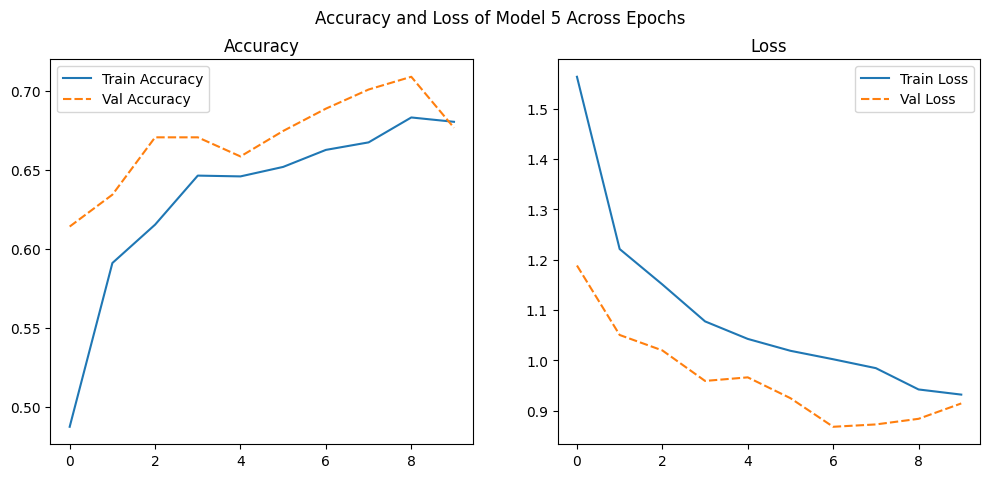

In [ ]:
data_acc_5 = pd.DataFrame({"Train Accuracy": train_accs_5, "Val Accuracy": val_accs_5})
data_loss_5 = pd.DataFrame({"Train Loss": train_losses_5, "Val Loss": val_losses_5})

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

plt.suptitle("Accuracy and Loss of Model 5 Across Epochs")

sns.lineplot(data=data_acc_5, ax = axs[0])
axs[0].set_title("Accuracy")


sns.lineplot(data=data_loss_5, ax = axs[1])
axs[1].set_title("Loss")

In [ ]:
result_5 = pd.concat([data_acc_5, data_loss_5], axis = 1)
result_5

,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.487212,0.614141,1.563366,1.188506
1,0.591023,0.634343,1.221243,1.050536
2,0.615346,0.670707,1.150861,1.019881
3,0.646439,0.670707,1.077536,0.959290
4,0.645938,0.658586,1.042745,0.966385
5,0.651956,0.674747,1.019127,0.925026
6,0.662738,0.688889,1.002339,0.868226
7,0.667503,0.701010,0.984669,0.872884
8,0.683300,0.709091,0.942346,0.884049
9,0.680542,0.676768,0.932126,0.914586


In [ ]:
with open('/content/drive/My Drive/filename.extension', 'w') as f:
  f.write("result_5.csv")